In [105]:
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from scipy.signal import periodogram
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/petal3/petal.csv


In [3]:
whole = pd.read_csv(('/kaggle/input/petal3/petal.csv'), parse_dates=["Date"])
# add train and test files later

print(whole['Date'].dtypes)# confirm the dates are set up as datetime

datetime64[ns]


**Begin Data Exploration**
Take a look at the data, columns names, data types.
Start by making a periodogram to see if there are seasonal and other features with periodic frequency to the time series.

In [5]:
whole.head()

,Date,Quantity,Account,Item,COGS Amount,Sales,Est. Unit Cost,Brand,Category,Description,Product Line
0,2015-02-18,2.0,4110 Revenue : candles : Sales - candles,CF-RS043,NaN,68.00,0.00,Cherish Chateau,NaN,"11.85oz, 100% natural soy wax Rose Water candl...",Petalume
1,2015-02-18,1.0,4810 Revenue : Shipping : Sales - Shipping,Fedex $12 Flat Rate,NaN,6.00,NaN,NaN,NaN,Petalume Flat Rate Shipping $12.00 Shipped Via...,NaN
2,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume
3,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume
4,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume


In [6]:
whole.rename(columns={'Est. Gross Profit (Line)': 'Sales'}, inplace=True)
whole.head()

,Date,Quantity,Account,Item,COGS Amount,Sales,Est. Unit Cost,Brand,Category,Description,Product Line
0,2015-02-18,2.0,4110 Revenue : candles : Sales - candles,CF-RS043,NaN,68.00,0.00,Cherish Chateau,NaN,"11.85oz, 100% natural soy wax Rose Water candl...",Petalume
1,2015-02-18,1.0,4810 Revenue : Shipping : Sales - Shipping,Fedex $12 Flat Rate,NaN,6.00,NaN,NaN,NaN,Petalume Flat Rate Shipping $12.00 Shipped Via...,NaN
2,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume
3,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume
4,2015-03-23,1.0,4110 Revenue : candles : Sales - candles,CF10101001,NaN,6.75,1.25,Petalume,Home,Petalume No. 1 2.5 oz,Petalume


In [7]:
print(len(whole))
whole.isna().sum()

1048575


Date                   0
Quantity           18125
Account             2917
Item                   0
COGS Amount       381138
Sales                  0
Est. Unit Cost    700930
Brand              47076
Category           47544
Description        10048
Product Line       46428
dtype: int64

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

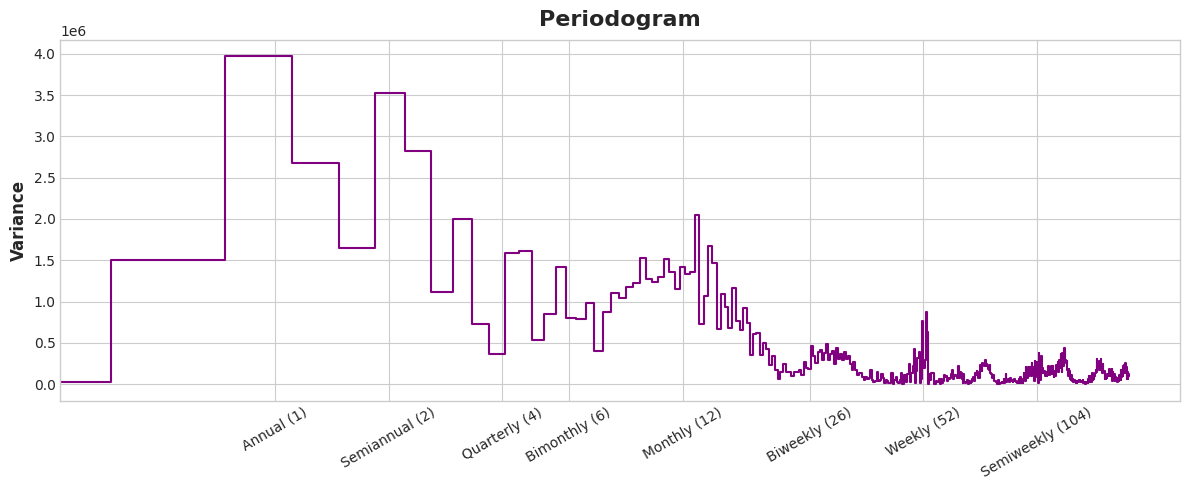

In [8]:
whole_sales=whole.groupby('Date')['Sales'].sum() 

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 5))
     
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)","Semiannual (2)","Quarterly (4)","Bimonthly (6)","Monthly (12)","Biweekly (26)","Weekly (52)","Semiweekly (104)",],rotation=30,)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(whole_sales)

The periodogram looks unusual. The annual peaks very high and wide and other peaks are jagged and indistinct. This could be due to inconsisent sales over time.

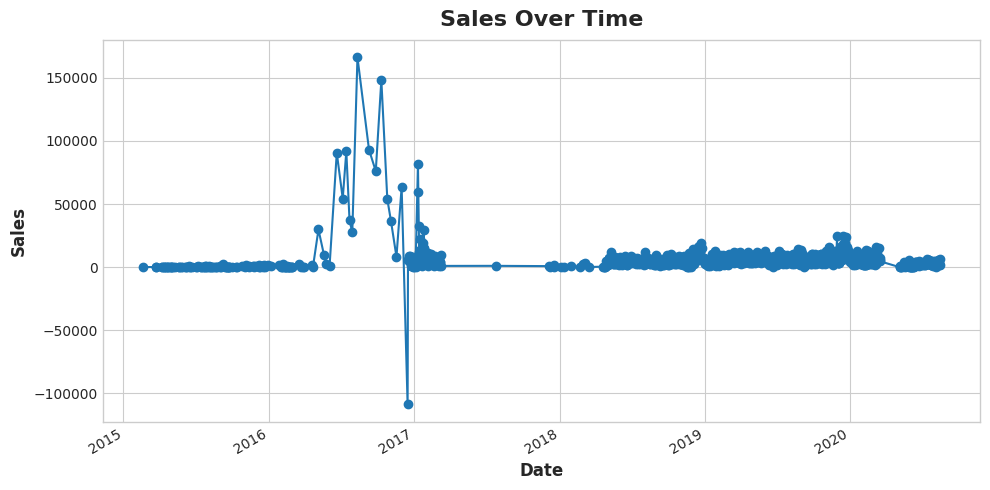

In [9]:

whole_sales = whole_sales.reset_index()
whole_sales.columns = ['Date', 'Sales']

whole_sales['Date'] = pd.to_datetime(whole_sales['Date'])


whole_sales.sort_values('Date', inplace=True)


plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(whole_sales['Date'], whole_sales['Sales'], marker='o')  # Plot with markers


plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')


plt.gcf().autofmt_xdate()

plt.show()



Here we can see that sales from mid-2016-2017 are much higher than the rest of the dataset. These high sales in 2016 will not be helful in predicting the sale behavior in the rest of the dataset. Additionally, there is an evident gap in sales in 2017. Take a closer look at the sales over time starting in 2018.

In [10]:
#find the end date for the dataset
whole_sales.tail()

,Date,Sales
984,2020-08-10,2396.42
985,2020-08-11,1461.30
986,2020-08-12,3311.80
987,2020-08-13,2034.81
988,2020-08-14,6522.06


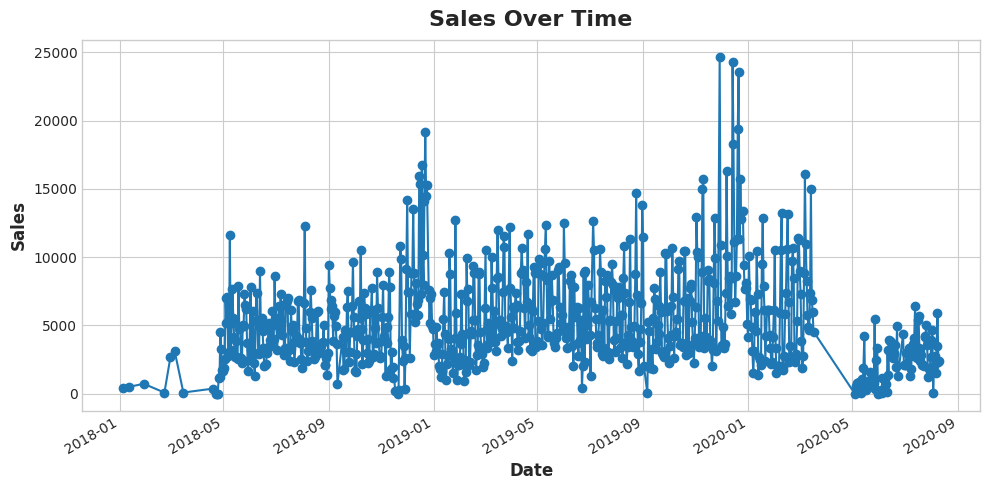

In [11]:
#limit the whole_sales dataset to dates starting in 2018 
whole_sales.set_index('Date', inplace=True)
whole_sales.sort_index(inplace=True)

# Slice the DataFrame to the desired date range
truncated_whole_sales = whole_sales.loc['2018-01-01':'2020-08-10']
#reset and resort the index for graphing 
truncated_whole_sales = truncated_whole_sales.reset_index()
whole_sales.sort_values('Date', inplace=True)

plt.figure(figsize=(10, 5)) 
plt.plot(truncated_whole_sales['Date'], truncated_whole_sales['Sales'], marker='o')  # Plot with markers


plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.gcf().autofmt_xdate()

plt.show()

This looks much better. It would be ideal to close in on the sections where there are no gaps. Closing into mid-April 2018 and ending with the expected sales pause on March 17, 2020.

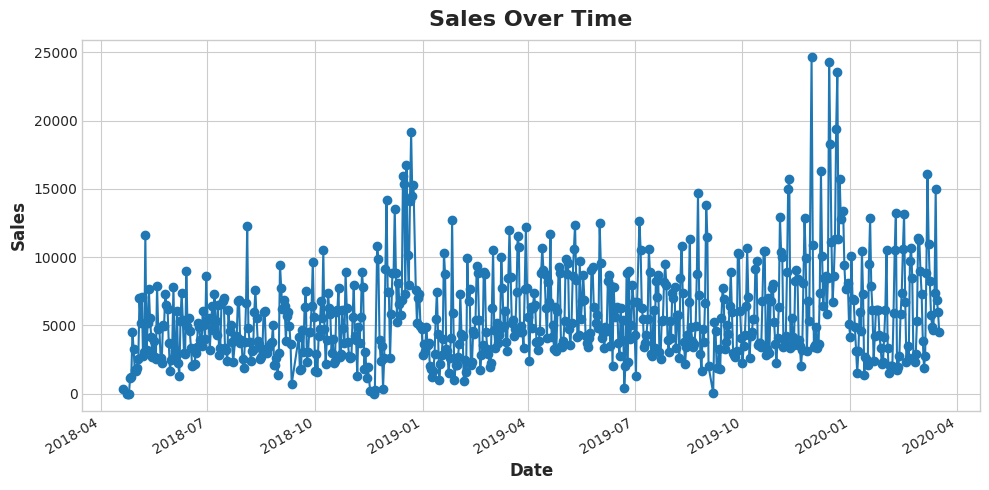

In [13]:
truncated_whole_sales = whole_sales.loc['2018-04-15':'2020-03-17']
#reset and resort the index for graphing 
truncated_whole_sales = truncated_whole_sales.reset_index()
#whole_sales.sort_values('Date', inplace=True)

plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(truncated_whole_sales['Date'], truncated_whole_sales['Sales'], marker='o')  # Plot with markers

plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.gcf().autofmt_xdate()

plt.show()

In [14]:
truncated_whole_sales.head(10) # starting sales with 04-26-2018

,Date,Sales
0,2018-04-20,379.80
1,2018-04-23,0.03
2,2018-04-24,0.00
3,2018-04-25,0.00
4,2018-04-26,1169.49
5,2018-04-27,1207.30
6,2018-04-28,4527.43
7,2018-04-29,3248.53
8,2018-04-30,1714.37
9,2018-05-01,1635.01


In [15]:
truncated_whole_sales = whole_sales.loc['2018-04-15':'2020-03-17']
#reset and resort the index for graphing 
truncated_whole_sales = truncated_whole_sales.reset_index()

truncated_whole_sales.head()

,Date,Sales
0,2018-04-20,379.80
1,2018-04-23,0.03
2,2018-04-24,0.00
3,2018-04-25,0.00
4,2018-04-26,1169.49


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

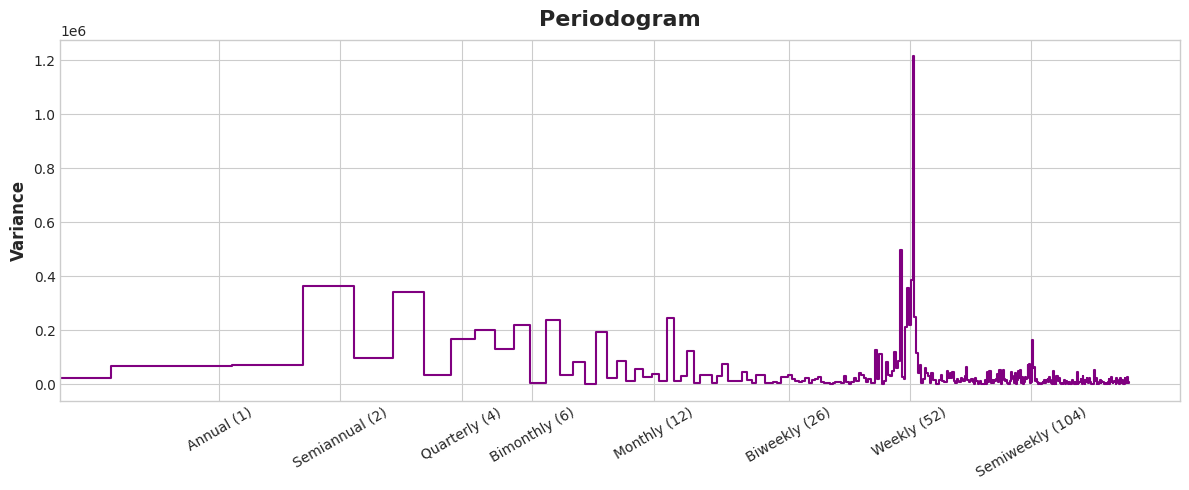

In [16]:
#Revisiting Periodogram
truncated_whole_sales=truncated_whole_sales.groupby('Date')['Sales'].sum()

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 5))
     
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)","Semiannual (2)","Quarterly (4)","Bimonthly (6)","Monthly (12)","Biweekly (26)","Weekly (52)","Semiweekly (104)",],rotation=30,)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

#plot_periodogram(aggsale_train)

plot_periodogram(truncated_whole_sales)

This is more similar to an expected periodogram. There seems to be a weekly component to sales, as well as monthly, bimonthly, quarterly, semiannually and annual patterns.
The next step is to create a model to capture these features, take a look at the model fit, and then use the model's prediction to confirm the periodogram is deseasoned when these features are implemented.
The first step here will be to split the model into a training set and a test set, such that time series predictions can be verified. For these purposes, 15 days of predicition should be sufficient.


In [17]:
whole.dtypes

Date              datetime64[ns]
Quantity                 float64
Account                   object
Item                      object
COGS Amount              float64
Sales                    float64
Est. Unit Cost           float64
Brand                     object
Category                  object
Description               object
Product Line              object
dtype: object

In [18]:
# Count the number of 0.0 values in a specific column
number_of_zeros = (whole['Quantity'] == 0.0).sum()
print(f"Number of 0.0 values in column '{'Quantity'}': {number_of_zeros}")


Number of 0.0 values in column 'Quantity': 37645


In [19]:
whole.set_index('Date', inplace=True)
#sort by the index
whole.sort_index(inplace=True)
#slice to set up train and test

train= whole.loc['2018-04-26':'2020-03-02']
test= whole.loc['2020-03-03':'2020-03-17']

aggsale_train = train['Sales'].groupby(train.index).sum()
aggsale_test = test['Sales'].groupby(test.index).sum()

aggsale_train.head()


Date
2018-04-26    1169.49
2018-04-27    1207.30
2018-04-28    4527.43
2018-04-29    3248.53
2018-04-30    1714.37
Name: Sales, dtype: float64

First convert the dates to periods with a frequency of daily for use in the model

In [20]:
aggsale_train = aggsale_train.asfreq('D')
print(aggsale_train.index.freq)

<Day>


In [21]:
print(aggsale_train.isna().sum())

19


There are 19 dates added to the time series that were previously missing. Take look to see if there is a pattern to missing dates.

In [22]:
aggsale_train = aggsale_train.reset_index()
aggsale_train.columns = ['Date', 'Sales']

nan_dates = aggsale_train[aggsale_train['Sales'].isna()]['Date']
print(nan_dates)

69    2018-07-04
89    2018-07-24
139   2018-09-12
140   2018-09-13
141   2018-09-14
142   2018-09-15
143   2018-09-16
204   2018-11-16
206   2018-11-18
207   2018-11-19
210   2018-11-22
243   2018-12-25
397   2019-05-28
434   2019-07-04
495   2019-09-03
496   2019-09-04
497   2019-09-05
581   2019-11-28
608   2019-12-25
Name: Date, dtype: datetime64[ns]


Some of these dates align with holiday store closures, Such as 12-25, 07-04. Others may relate to store closures near Thanksgiving and Labor Day. The best way to deal with these nan (no entry in the sales column) is to convert them to 0's, indicating no sales.

In [23]:
aggsale_train['Sales'].fillna(0, inplace = True)
aggsale_train.isna().sum()


Date     0
Sales    0
dtype: int64

In [24]:
#Convert dataframe back to periodic frequency
aggsale_train.set_index('Date', inplace=True)
aggsale_train = aggsale_train.asfreq('D')
print(aggsale_train.index.freq)

<Day>


In [25]:
#create a model
y = aggsale_train.copy()
fourier = CalendarFourier(freq='M', order=4)
fourier_annual = CalendarFourier(freq='A', order=4)
fourier_weekly = CalendarFourier(freq='W', order=4)
fourier_quarterly = CalendarFourier(freq='Q', order=4)
# Bimonthly Fourier
fourier_bimonthly = CalendarFourier(freq='2M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier,fourier_weekly,fourier_annual,fourier_quarterly, fourier_bimonthly],
    drop=True,
)
X = dp.in_sample()

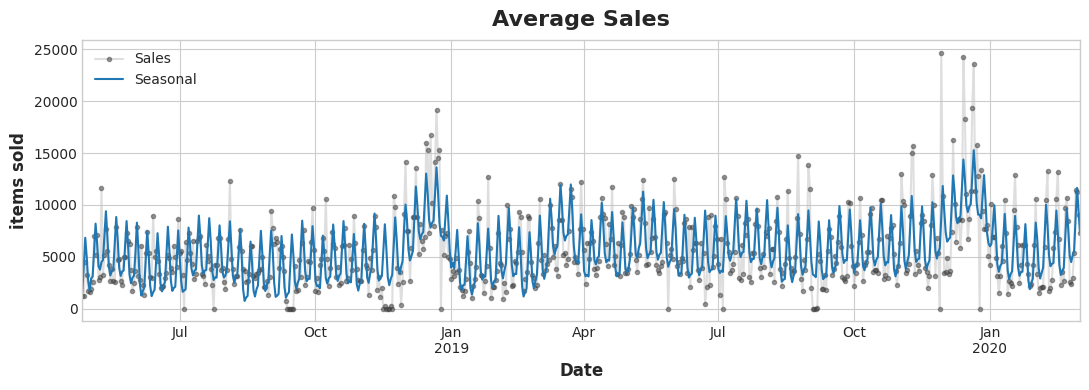

In [26]:
#Run the model
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X)[:, 0], #this flattens by slicing
    index=X.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Root Mean Squared Logrithmin Error (RSMLE) is a method of measuring the error in the curve generated in the model compared to original samples. 


In [28]:
def rmsle(y_true, y_pred):
    
    # Ensure the arrays are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute the squared logarithmic error
    error = (np.log(y_pred + 1) - np.log(y_true + 1)) ** 2
    
    # Return the square root of the mean of the squared logarithmic error
    return np.sqrt(np.mean(error))

In [29]:
in_sample_rmsle = rmsle(y, y_pred)
print(f"In-sample RMSLE: {in_sample_rmsle}")

In-sample RMSLE: 1.674832014000963


RSMLE values are relative, it will be compared to out-sample (future prediction generated from the test set) as well as further modifications for the model. A lower value is lower error in the model.
Next, verify that the main features of the periodogram have been captured by the model, by generating a priodogram with the model substrated.

In [30]:
y_squ = np.squeeze(y)
print(y_squ.shape)
print(X.shape)

(677,)
(677, 40)


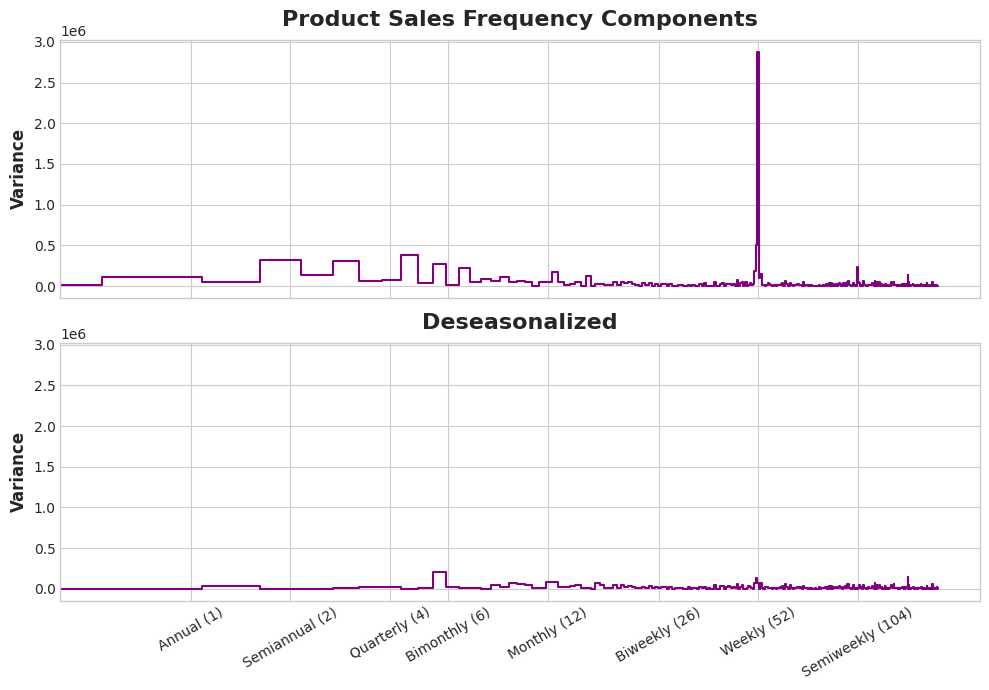

In [31]:
#deseason the data and look at the periodogram to see if any more seasonailty not captured
y_deseason = y_squ - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_squ, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");
#it appears that seaonality of the slaes is captured

The seasonality of the data looks to be covered in the model. 
Now, exploring additional features to add to the model.
Starting by taking a look at days of the week, days of the month, sales across weeks, months and years to look for any trends that may not have been captured in the model.

In [32]:
aggsale_train = aggsale_train.reset_index()
print(aggsale_train.columns)
aggsale_train.head()

Index(['Date', 'Sales'], dtype='object')


,Date,Sales
0,2018-04-26,1169.49
1,2018-04-27,1207.30
2,2018-04-28,4527.43
3,2018-04-29,3248.53
4,2018-04-30,1714.37


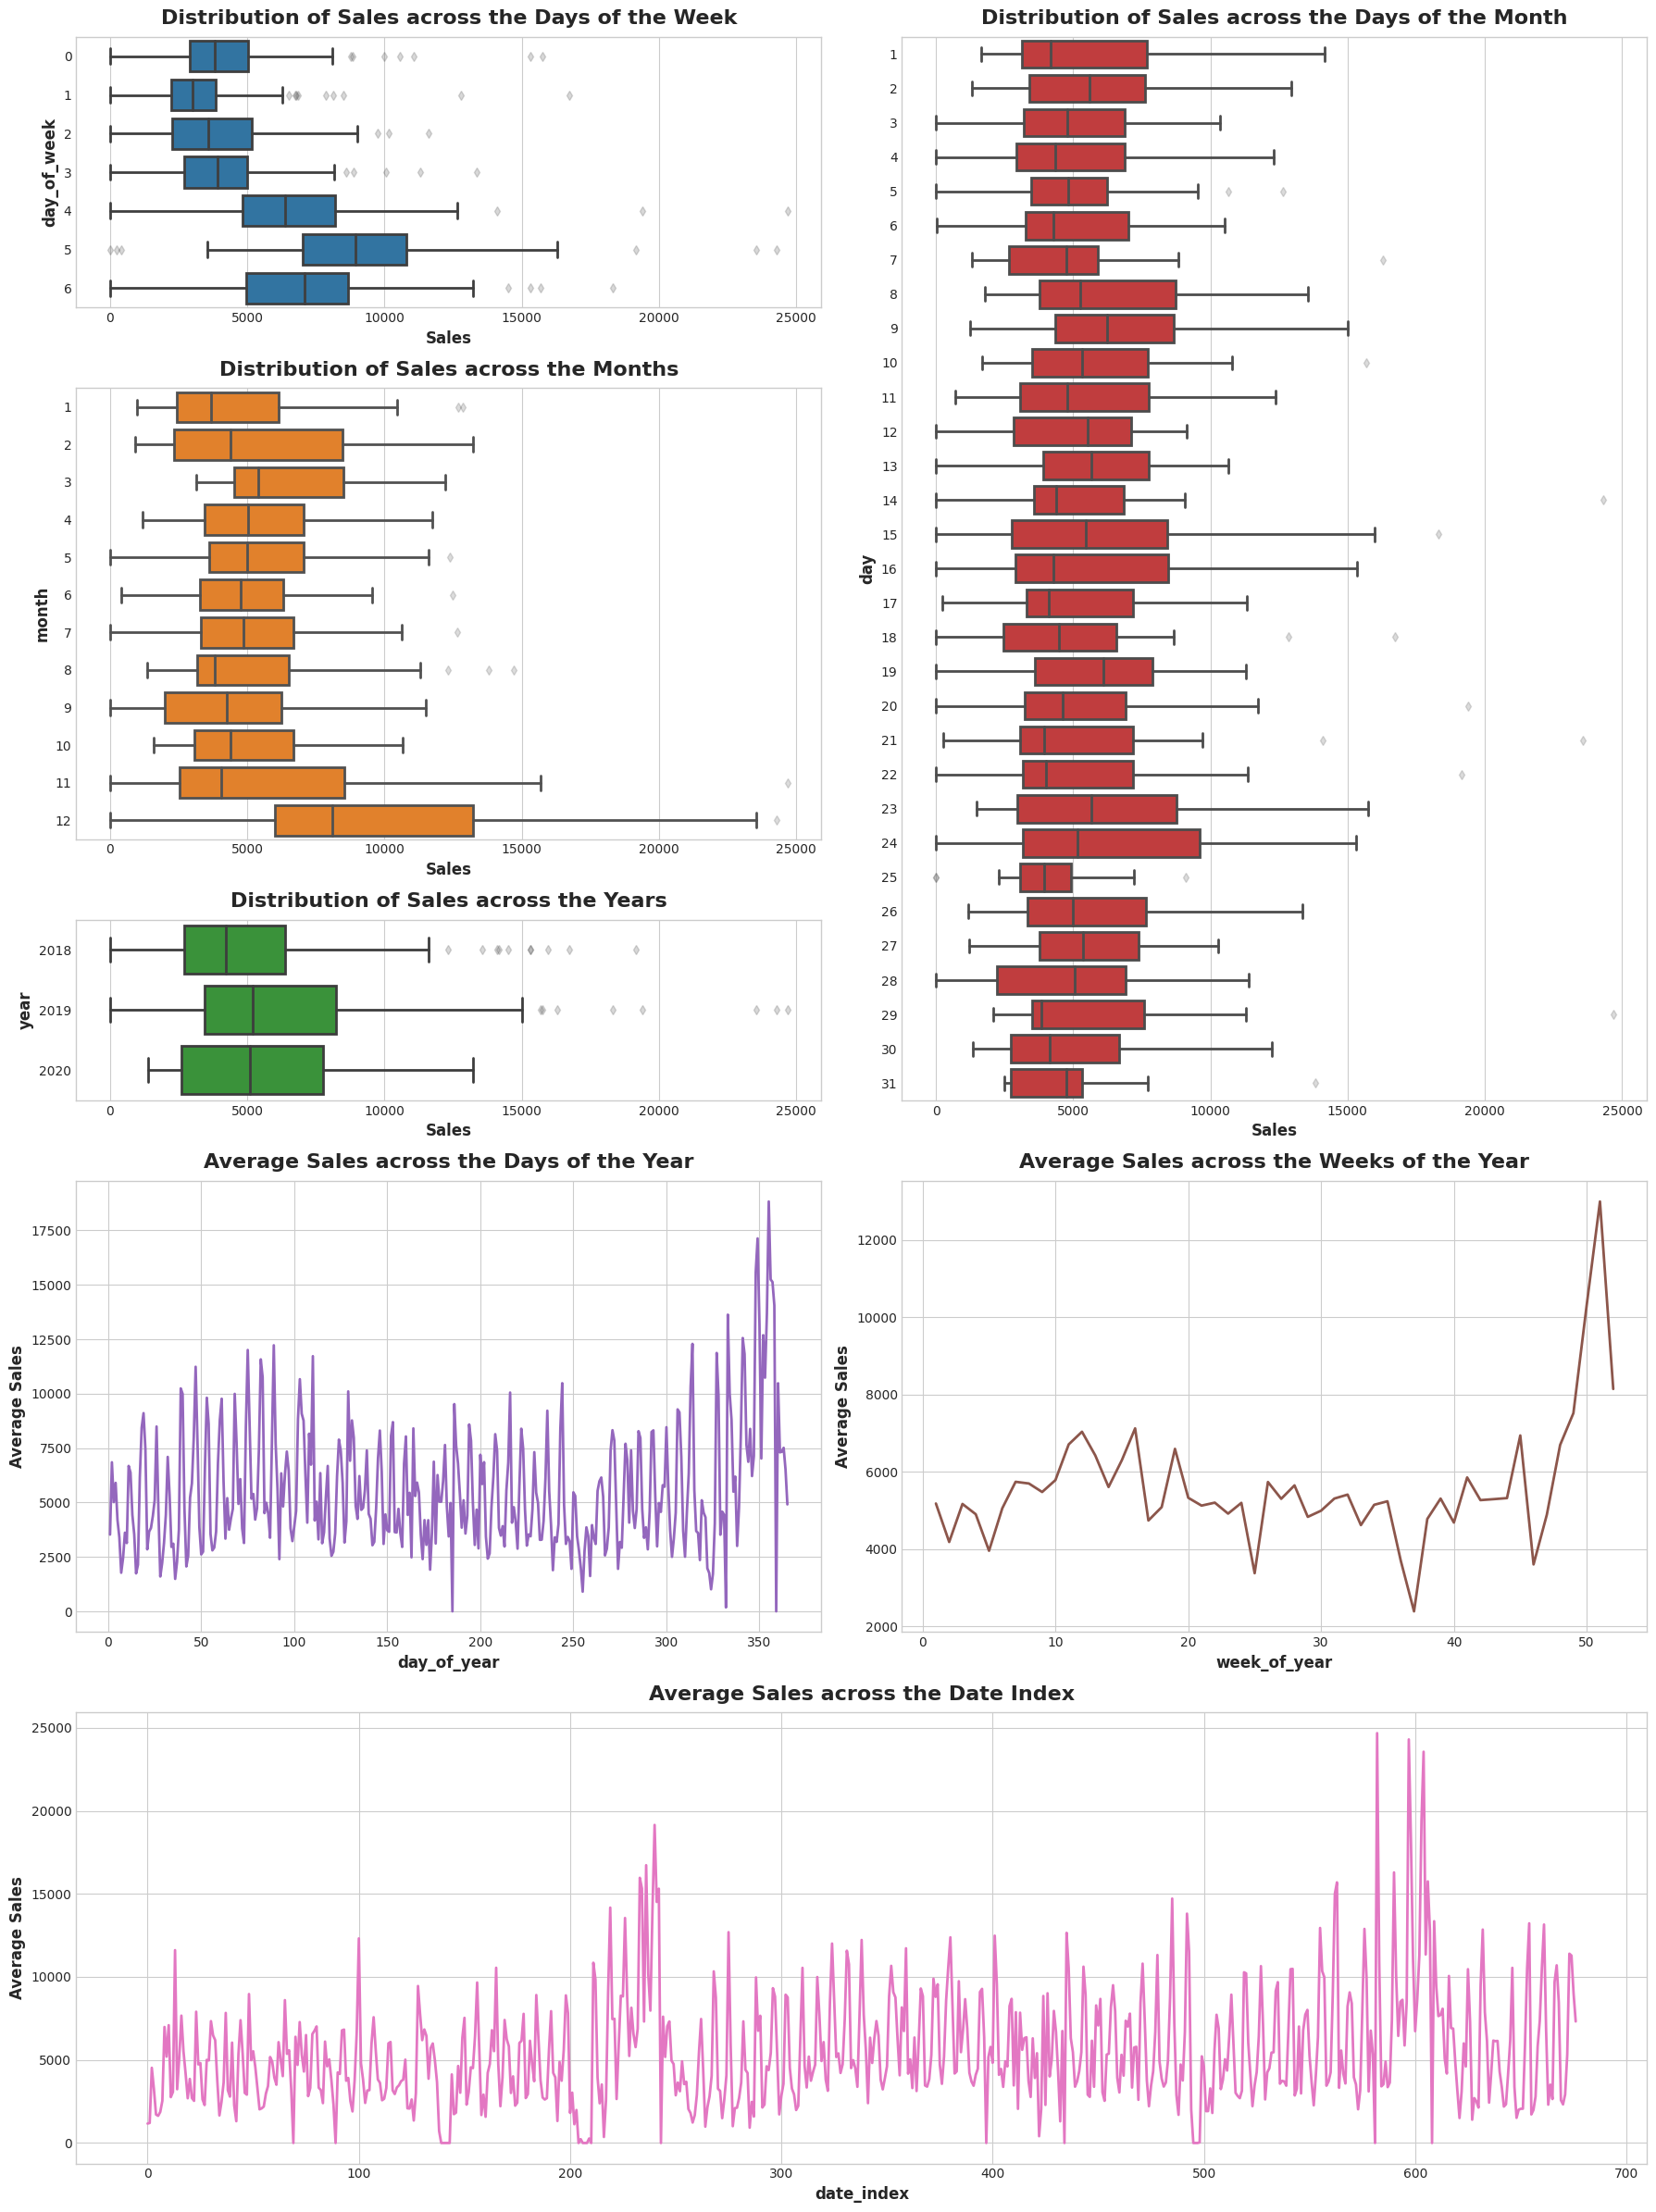

In [33]:

COLORS = list(sns.color_palette())
def plot_date_distribution():   
    
    df = aggsale_train.copy().sort_values(["Date"], ignore_index=True)
    df["day"] = df.Date.dt.day
    df["month"] = df.Date.dt.month
    df["year"] = df.Date.dt.year
    df["day_of_week"] = df.Date.dt.dayofweek
    df["day_of_year"] = df.Date.dt.dayofyear
    df["week_of_year"] = df.Date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.Date.factorize()[0]
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",}
    
    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))
    sns.boxplot(
        data=df,
        y="day_of_week",
        x="Sales",
        color=COLORS[0],
        ax=fig.add_subplot(gs[0, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Week")
    
    sns.boxplot(
        data=df,
        y="month",
        x="Sales",
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]),
        **plot_kwargs,
         )
    plt.title("Distribution of Sales across the Months")
    
    sns.boxplot(
        data=df,
        y="year",
        x="Sales",
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Years")
    
    sns.boxplot(
        data=df,
        y="day",
        x="Sales",
        color=COLORS[3],
                ax=fig.add_subplot(gs[:3, 1]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Month")
    sns.lineplot(
        data=df.groupby("day_of_year").Sales.mean().reset_index(),
        x="day_of_year",
        y="Sales",
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Days of the Year")
    
    sns.lineplot(
        data=df.groupby("week_of_year").Sales.mean().reset_index(),
        x="week_of_year",
        y="Sales",
        color=COLORS[5],
        ax=fig.add_subplot(gs[3, 1]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Weeks of the Year")
        
    sns.lineplot(
        data=df.groupby("date_index").Sales.mean().reset_index(),
        x="date_index",
        y="Sales",
        color=COLORS[6],
        ax=fig.add_subplot(gs[4, :]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Date Index")
    
    plt.tight_layout()
    plt.show()
    
plot_date_distribution()
    

The sales are higher on Saturdays, and then Sundays and Mondays. The day of the week feature should already covered by the weekly feature in the model (this was confirmed separately and addition of a day of the week feature did not affect the model, so was omitted). There is no particular trend apparent in the day of the month or yearly graphs. Sales are highest Nov-Dec, as expected, and this is likely covered with the annual feature in the model.

Moving forward, adding in specific holidays that repeat annually, adding in days with 0 sales (store closed) as a feature, and then investigating features exploring sales categories, brands and products.

In [34]:
y_deseason = y_squ - y_pred
average_sales_value = y_deseason.median() 
holiday_deviations = abs(y_deseason[aggsale_train.index] - average_sales_value)
impactful_holidays = holiday_deviations.sort_values(ascending=False)
impactful_holidays.head() 


Date
2019-11-29    16116.026167
2019-12-14    10126.733266
2018-12-18     9126.648943
2019-12-25     8859.680311
2019-06-22     8844.888910
dtype: float64

In [35]:
impactful_holidays = impactful_holidays.reset_index()
print(impactful_holidays.columns)
impactful_holidays.head(20)



Index(['Date', 0], dtype='object')


,Date,0
0,2019-11-29,16116.026167
1,2019-12-14,10126.733266
2,2018-12-18,9126.648943
3,2019-12-25,8859.680311
4,2019-06-22,8844.888910
5,2019-12-21,8486.513904
6,2018-10-08,7842.964281
7,2018-11-17,7698.120469
8,2018-06-13,7592.575003
9,2018-05-09,7332.701450


In [36]:

#Create a 'month_day' column to hold the month and day
impactful_holidays['month_day'] = impactful_holidays['Date'].dt.strftime('%m-%d')

# Sort the dataframe by 'month_day' and the impact scores in descending order
impactful_holidays_sorted = impactful_holidays.sort_values(by=['month_day', 0], ascending=[True, False])


# This function will check if there are high impact scores on the same 'month_day' across different years
def filter_high_impact_days(group):
    if group['Date'].dt.year.nunique() > 1:  # Checking if there are entries from multiple years
        return group

# Apply the filter function to each group
high_impact_dates = impactful_holidays_sorted.groupby('month_day').apply(filter_high_impact_days)

# If you want to reset the index to get a clean dataframe
high_impact_dates.reset_index(drop=True, inplace=True)

print(high_impact_dates)


          Date            0 month_day
0   2020-01-01  1619.866288     01-01
1   2019-01-01   883.085825     01-01
2   2020-01-02  4017.046179     01-02
3   2019-01-02   592.490699     01-02
4   2020-01-03  1021.276033     01-03
..         ...          ...       ...
617 2019-12-29  2452.103873     12-29
618 2018-12-30  3329.266487     12-30
619 2019-12-30   969.556523     12-30
620 2019-12-31  1022.717166     12-31
621 2018-12-31   556.517334     12-31

[622 rows x 3 columns]


In [37]:
# Group by 'month_day' and get the maximum impact score for each group
max_impact_scores = high_impact_dates.groupby('month_day')[0].max().reset_index()

# Sort the result by the impact score in descending order to have the highest impacts at the top
max_impact_scores_sorted = max_impact_scores.sort_values(by=0, ascending=False).reset_index(drop=True)

# Now max_impact_scores_sorted will have the highest impact score for each month-day, sorted from highest to lowest
max_impact_scores_sorted.head(30)


,month_day,0
0,11-29,16116.026167
1,12-14,10126.733266
2,12-18,9126.648943
3,12-25,8859.680311
4,06-22,8844.888910
5,12-21,8486.513904
6,10-08,7842.964281
7,11-17,7698.120469
8,06-13,7592.575003
9,05-09,7332.701450


In [38]:
#it looks like there are high impact sales in the days leading up to Christmas, determine which days to use
start_date = '12-14'
end_date = '12-25'

# Filter the DataFrame based on the date range
filtered_df = max_impact_scores_sorted[(max_impact_scores_sorted['month_day'] >= start_date) & (max_impact_scores_sorted['month_day'] <= end_date)]

print(filtered_df)
# sorting through excel reveals that the average impact is highest 12-21 thru 12-25 both yea

    month_day             0
1       12-14  10126.733266
2       12-18   9126.648943
3       12-25   8859.680311
5       12-21   8486.513904
11      12-24   7242.162907
13      12-20   6936.573561
16      12-15   6021.221071
20      12-23   5787.252190
21      12-22   5725.527964
43      12-16   4404.818933
118     12-17   2375.817030
132     12-19   2087.981546


In [39]:
aggsale_train['Date'].dtypes

dtype('<M8[ns]')

In [40]:
# take a look to confirm that sales where far above or below median on particular dates as indicated above

particular_date = '2019-12-18'

# Convert the string to a datetime object
particular_date = pd.to_datetime(particular_date)

# Use loc to filter the dataframe for the particular date
sales_on_particular_date = aggsale_train.loc[aggsale_train['Date'] == particular_date]

print(sales_on_particular_date)

          Date    Sales
601 2019-12-18  8649.47


It looks like December 20-25 could have an impact on the model. Additionally, December 18 and 14 could have an impact. 
The model will be run with and without these additional dates to see the impact on the RSMLE, but first, more features.  

In [41]:
#new column called store closed that has a 1 when sales = 0  
aggsale_train['Store_closed'] = (aggsale_train['Sales'] == 0).astype(int)
aggsale_train.head()


,Date,Sales,Store_closed
0,2018-04-26,1169.49,0
1,2018-04-27,1207.30,0
2,2018-04-28,4527.43,0
3,2018-04-29,3248.53,0
4,2018-04-30,1714.37,0


In [42]:
# now, do the same for aggsale_test, convert to dataframe first
aggsale_test = aggsale_test.reset_index()
#print(aggsale_test.columns)
aggsale_test['Store_closed'] = (aggsale_test['Sales'] == 0).astype(int)
aggsale_test.head()

,Date,Sales,Store_closed
0,2020-03-03,3887.75,0
1,2020-03-04,1913.80,0
2,2020-03-05,2734.92,0
3,2020-03-06,8847.66,0
4,2020-03-07,16059.85,0


Next, exploring features based on Account categories.
create account_type column in train df ( the df filtered for dates from whole, contains all columns), get dummies, then merge with aggsale_train grouped by date with sum or sales and of each account_type column

In [43]:

train_at = train
train_at = train_at.drop(['Item', 'COGS Amount','Est. Unit Cost','Category','Product Line'], axis=1)
train_at.head()



,Quantity,Account,Sales,Brand,Description
Date,,,,,
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz
2018-04-26,0.0,5110 Cost of Goods Sold : Material : Std Cost ...,0.0,Petalume,Petalume No. 70 2.5 oz


In [44]:
conditions = [
    train_at['Account'].str.contains('Inventory', case=False, na=False),
    train_at['Account'].str.contains('Cost of Goods', case=False, na=False),
    train_at['Account'].str.contains('Logistics', case=False, na=False),    
    train_at['Account'].str.contains('Revenue', case=False, na=False) & train['Account'].str.contains('candles', case=False, na=False),
    train_at['Account'].str.contains('Revenue', case=False, na=False) & train['Account'].str.contains('Accessories', case=False, na=False),
    train_at['Account'].str.contains('Workshop', case=False, na=False),
    ]

# Define the choices corresponding to conditions
choices = [
    'Inventory',
    'Cost of Goods',
    'Logistics',
    'Revenue candles',
    'Revenue Accessories',
    'Revenue Workshop',
    ]

# Create the new column using np.select()

train_at['Account_type'] = np.select(conditions, choices, default=np.nan)


train_at.head()

,Quantity,Account,Sales,Brand,Description,Account_type
Date,,,,,,
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz,Revenue candles
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz,Revenue candles
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz,Revenue candles
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,0.0,Petalume,Petalume No. 70 2.5 oz,Revenue candles
2018-04-26,0.0,5110 Cost of Goods Sold : Material : Std Cost ...,0.0,Petalume,Petalume No. 70 2.5 oz,Cost of Goods


In [45]:
test_at = test
conditions = [
    test_at['Account'].str.contains('Inventory', case=False, na=False),
    test_at['Account'].str.contains('Cost of Goods', case=False, na=False),
    test_at['Account'].str.contains('Logistics', case=False, na=False),    
    test_at['Account'].str.contains('Revenue', case=False, na=False) & test_at['Account'].str.contains('candles', case=False, na=False),
    test_at['Account'].str.contains('Revenue', case=False, na=False) & test_at['Account'].str.contains('Accessories', case=False, na=False),
    test_at['Account'].str.contains('Workshop', case=False, na=False),
    ]

# Define the choices corresponding to conditions
choices = [
    'Inventory',
    'Cost of Goods',
    'Logistics',
    'Revenue candles',
    'Revenue Accessories',
    'Revenue Workshop',
    
]

# Create the new column using np.select()

test_at['Account_type'] = np.select(conditions, choices, default=np.nan)


test_at.head()

,Quantity,Account,Item,COGS Amount,Sales,Est. Unit Cost,Brand,Category,Description,Product Line,Account_type
Date,,,,,,,,,,,
2020-03-03,1.0,4110 Revenue : candles : Sales - candles,BRD114,14.0,10.0,14.0,BR Design,Home,Medium Clay Drop Earrings,BR Design,Revenue candles
2020-03-03,1.0,5110 Cost of Goods Sold : Material : Std Cost ...,BRD114,-14.0,-14.0,NaN,BR Design,Home,Medium Clay Drop Earrings,BR Design,Cost of Goods
2020-03-03,-1.0,1210 Inventory : Inventory - Raw Materials,BRD114,NaN,14.0,NaN,BR Design,Home,Medium Clay Drop Earrings,BR Design,Inventory
2020-03-03,NaN,4120 Revenue : candles : Sales Discounts - can...,Employee Discount,NaN,0.0,NaN,NaN,NaN,Employee Discount,NaN,Revenue candles
2020-03-03,0.0,4110 Revenue : candles : Sales - candles,CF10101090,0.0,0.0,NaN,Petalume,Home,Petalume No. 90 2.5 oz,Petalume,Revenue candles


In [46]:
train_at['Account_type'].unique().tolist()

['Revenue candles',
 'Cost of Goods',
 'Inventory',
 'Revenue Accessories',
 'nan',
 'Revenue Workshop',
 'Logistics']

In [47]:
# Replace NaN with a placeholder value,'Unknown', then create dummies and concat
train_at['Account_type'] = train_at['Account_type'].fillna('Unknown')
test_at['Account_type'] = test_at['Account_type'].fillna('Unknown')
account_type_dummies = pd.get_dummies(train_at['Account_type']).astype(int)
account_type_dummies_test = pd.get_dummies(test_at['Account_type']).astype(int)


account_type_dummies.head()

,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan
Date,,,,,,,
2018-04-26,0,0,0,0,0,1,0
2018-04-26,0,0,0,0,0,1,0
2018-04-26,0,0,0,0,0,1,0
2018-04-26,0,0,0,0,0,1,0
2018-04-26,1,0,0,0,0,0,0


In [49]:

train_gr = train_at.drop(['Quantity','Account','Description'], axis =1)
train_gr.head()

,Sales,Brand,Account_type
Date,,,
2018-04-26,0.0,Petalume,Revenue candles
2018-04-26,0.0,Petalume,Revenue candles
2018-04-26,0.0,Petalume,Revenue candles
2018-04-26,0.0,Petalume,Revenue candles
2018-04-26,0.0,Petalume,Cost of Goods


In [50]:

number_of_revenue_workshops = (train_gr['Account_type'] == 'Revenue Workshop').sum()
print(f"Number of 'Revenue Workshop' entries: {number_of_revenue_workshops}")


Number of 'Revenue Workshop' entries: 502


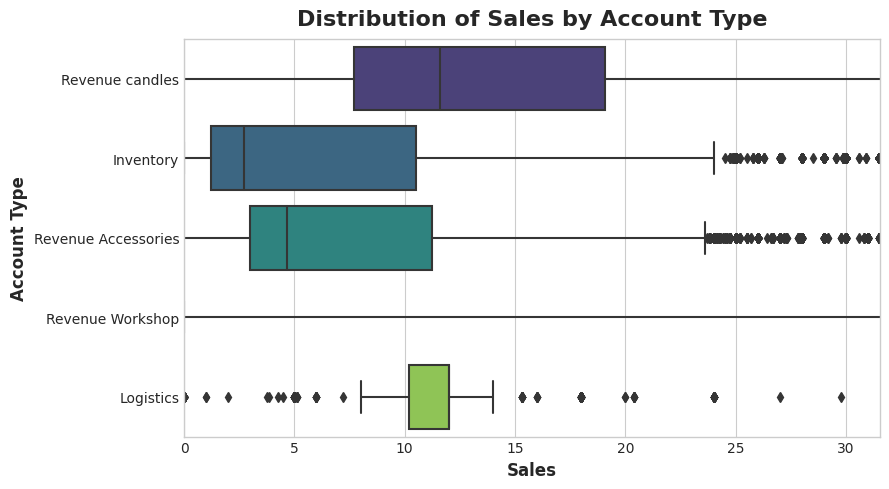

In [52]:

def plot_date_distribution(df):
    
    df_red = df[(df['Account_type'] != 'Cost of Goods')  & (df['Account_type'] != 'nan')]

    plt.figure(figsize=(9, 5))
    ax = sns.boxplot(
        data=df_red,
        x="Sales",
        y="Account_type",
        palette="viridis"
    )
    
    q1 = df_red['Sales'].quantile(0.25)
    q3 = df_red['Sales'].quantile(0.75)
    iqr = q3 - q1

    
    #ax.set_xlim([q1 - 1.5 * iqr, q3 + 1.5 * iqr])
    ax.set_xlim([0, q3 + 1.5 * iqr])

    plt.title("Distribution of Sales by Account Type")
    plt.xlabel("Sales")
    plt.ylabel("Account Type")
    plt.show()

# Call the function with your data
plot_date_distribution(train_gr)


    

In [53]:
# Inspect the data for "Workshops"
workshops_data = train_gr[train_gr['Account_type'] == 'Revenue Workshop']
print(workshops_data['Sales'].describe())


count     502.000000
mean      165.176793
std       200.186601
min         0.000000
25%        55.000000
50%       110.000000
75%       220.000000
max      2272.650000
Name: Sales, dtype: float64


In [54]:
# Filter to find the specific rows where 'Account_type' is 'Revenue Workshop' and 'Sales' is 2272
outliers = train_gr[(train_gr['Account_type'] == 'Revenue Workshop') & (train_gr['Sales'] >= 800)]

# Print the outlier rows to investigate
print(outliers)


              Sales Brand      Account_type
Date                                       
2018-05-02   840.00   NaN  Revenue Workshop
2018-05-24   840.00   NaN  Revenue Workshop
2018-07-02  1200.00   NaN  Revenue Workshop
2018-09-27  1522.50   NaN  Revenue Workshop
2018-11-27  1080.00   NaN  Revenue Workshop
2019-01-13  2272.65   NaN  Revenue Workshop
2019-07-08   900.00   NaN  Revenue Workshop
2019-07-08   960.00   NaN  Revenue Workshop


Revenue workshops seemed to have high values, but they appear to be legitimate. Try adjusting to log scale to adjust for these high values.

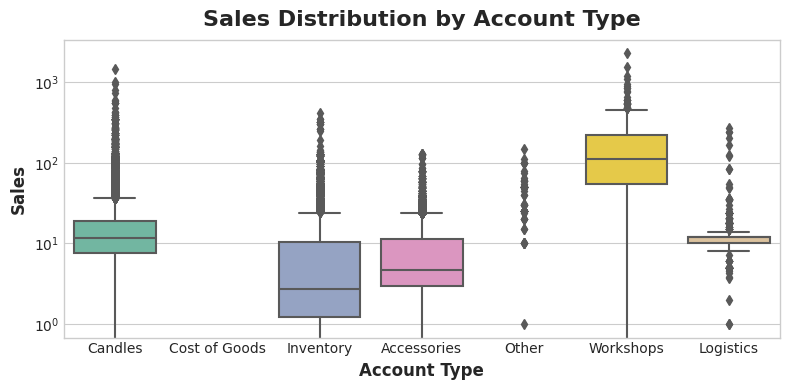

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
ax = sns.boxplot(x='Account_type', y='Sales', data=train_gr, palette='Set2')

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

plt.xticks([0,1,2,3,4,5,6], ["Candles", "Cost of Goods", "Inventory",'Accessories','Other','Workshops','Logistics'])
plt.title('Sales Distribution by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Sales')
plt.show()


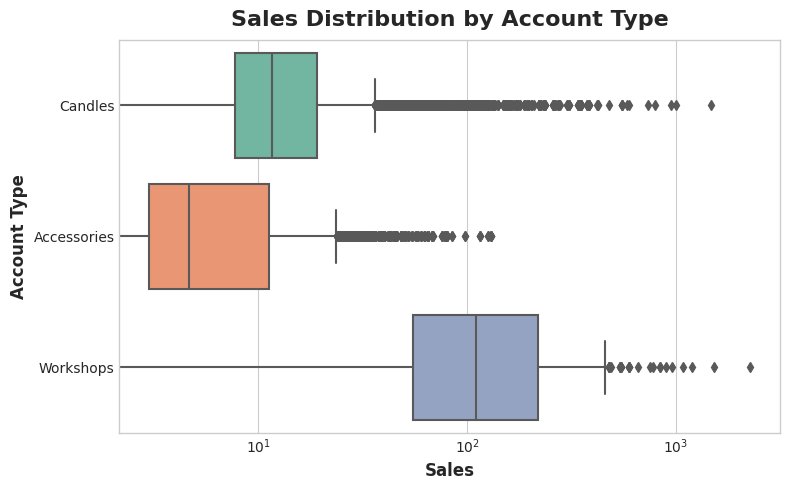

In [57]:

df_filtered = train_gr[(train_gr['Account_type'] != 'Cost of Goods') & 
                       (train_gr['Account_type'] != 'Inventory') &
                       (train_gr['Account_type'] != 'nan') &
                       (train_gr['Account_type'] != 'Logistics') &
                       (~pd.isna(train_gr['Account_type']))]

# Now create the plot using df_filtered
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x='Sales', y='Account_type', data=df_filtered, palette='Set2')

# Set the y-axis to a logarithmic scale
ax.set_xscale('log')

plt.yticks([0,1,2], ["Candles", 'Accessories','Workshops'])
plt.title('Sales Distribution by Account Type')
plt.xlabel('Sales')
plt.ylabel('Account Type')
plt.show()


In [58]:
# Aggregate the dummies at a daily level
account_dummies_agg = account_type_dummies.groupby('Date').sum() 
account_dummies_agg_t = account_type_dummies_test.groupby('Date').sum() 

account_dummies_agg.head()

,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan
Date,,,,,,,
2018-04-26,87,87,0,22,0,70,2
2018-04-27,122,122,0,15,0,119,4
2018-04-28,316,316,0,54,1,272,2
2018-04-29,260,260,0,22,0,260,0
2018-04-30,115,115,0,27,1,94,2


In [59]:
account_dummies_agg = account_dummies_agg.reset_index()
account_dummies_agg_t = account_dummies_agg_t.reset_index()
account_dummies_agg_t.head()

,Date,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan
0,2020-03-03,242,242,0,10,2,248,0
1,2020-03-04,164,164,1,4,0,172,6
2,2020-03-05,178,178,0,4,0,189,0
3,2020-03-06,636,636,9,36,0,627,5
4,2020-03-07,1045,1045,5,47,1,1028,22


In [60]:
# Merge
aggsale_train= aggsale_train.merge(account_dummies_agg, on='Date', how='left')
aggsale_test= aggsale_test.merge(account_dummies_agg_t, on='Date', how='left')
aggsale_train.head()


,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan
0,2018-04-26,1169.49,0,87.0,87.0,0.0,22.0,0.0,70.0,2.0
1,2018-04-27,1207.30,0,122.0,122.0,0.0,15.0,0.0,119.0,4.0
2,2018-04-28,4527.43,0,316.0,316.0,0.0,54.0,1.0,272.0,2.0
3,2018-04-29,3248.53,0,260.0,260.0,0.0,22.0,0.0,260.0,0.0
4,2018-04-30,1714.37,0,115.0,115.0,0.0,27.0,1.0,94.0,2.0


Next, adding features for Brands and Product type. There are 135 unique brands in the dataset. In order to see the top ten brands by sales, group the date by brand and sum the sales for each category. 

In [61]:
aggsale_test.head()

,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan
0,2020-03-03,3887.75,0,242,242,0,10,2,248,0
1,2020-03-04,1913.80,0,164,164,1,4,0,172,6
2,2020-03-05,2734.92,0,178,178,0,4,0,189,0
3,2020-03-06,8847.66,0,636,636,9,36,0,627,5
4,2020-03-07,16059.85,0,1045,1045,5,47,1,1028,22


In [62]:
train['Brand'].nunique()

135

In [63]:
brand_sales_sum = train_gr.groupby('Brand')['Sales'].sum()

# Sort the sums in descending order and get the top 10
top_ten_brands = brand_sales_sum.sort_values(ascending=False).head(10)

# Print the top 10 brands
print(top_ten_brands)


Brand
Petalume                 2342125.19
AromaGarden               762546.62
Hearth Harbor              83481.71
Cozy Corner                44933.67
Meadow Mingle              40627.26
Tranquil Trove             37939.36
Serene Sphere              18724.64
Bliss Bungalow             18724.20
Vivid Nook                 14300.76
Charleston candle Co.      13615.29
Name: Sales, dtype: float64


In [64]:
brand_sales_sumt = test.groupby('Brand')['Sales'].sum()
top_ten_brandst = brand_sales_sumt.sort_values(ascending=False).head(10)


print(top_ten_brandst)


Brand
Petalume           71828.76
AromaGarden        25583.63
Hearth Harbor       2779.50
Meadow Mingle       1171.20
Bliss Bungalow      1020.75
Northern Lights      777.45
1Canoe2              347.60
Steel Birch          301.15
Cozy Corner          284.50
Bitchstix            228.50
Name: Sales, dtype: float64


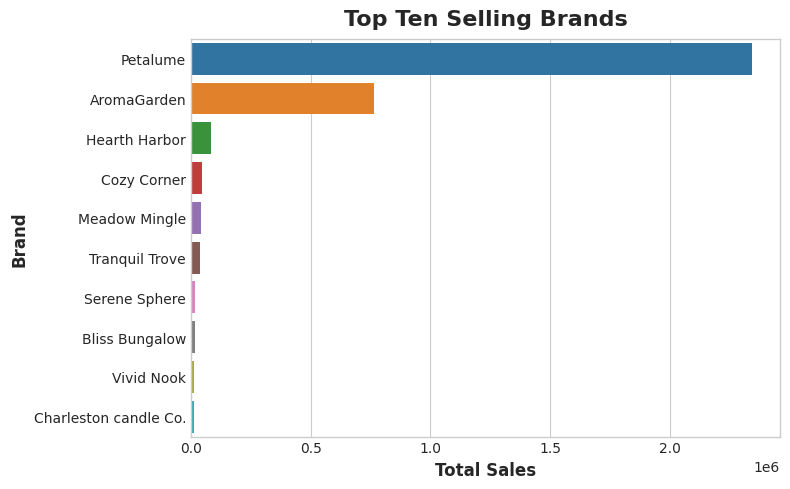

In [65]:
plt.figure(figsize=(8, 5))
sns.barplot(x=top_ten_brands.values, y=top_ten_brands.index)
plt.title('Top Ten Selling Brands')
plt.xlabel('Total Sales')
plt.ylabel('Brand')
plt.show()


Now, make a feature with the brands that are in common for both the training and test datasets

In [66]:
set1 = set(top_ten_brands.index)
set2 = set(top_ten_brandst.index)

common_brands = set1.intersection(set2)
common_brands_list = list(common_brands)
print(common_brands_list)


['Cozy Corner', 'Petalume', 'Bliss Bungalow', 'AromaGarden', 'Hearth Harbor', 'Meadow Mingle']


In [67]:
def categorize_brand(brand):
    if brand in common_brands_list:
        return brand
    else:
        return 'Other'

# Apply the function to the 'Brand' column
train_at['Common_Brand'] = train_at['Brand'].apply(categorize_brand)
test_at['Common_Brand'] = test_at['Brand'].apply(categorize_brand)

# Create dummy variables
brand_dummies_train = pd.get_dummies(train_at['Common_Brand']).astype(int)
brand_dummies_test = pd.get_dummies(test_at['Common_Brand']).astype(int)

# Checking the result
brand_dummies_train.head()


,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Other,Petalume
Date,,,,,,,
2018-04-26,0,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,0,1


In [68]:
brand_dummies_train = brand_dummies_train.drop(['Other'], axis =1)
brand_dummies_test = brand_dummies_test.drop(['Other'], axis =1)
brand_dummies_train.head()

,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
Date,,,,,,
2018-04-26,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,1
2018-04-26,0,0,0,0,0,1


In [69]:
brand_dummies_test.head()

,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
Date,,,,,,
2020-03-03,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,1


In [70]:
#aggregate by sales per day, reset inddex and then merge
brand_dummies_agg = brand_dummies_train.groupby('Date').sum() 
brand_dummies_agg_t = brand_dummies_test.groupby('Date').sum() 
brand_dummies_agg = brand_dummies_agg.reset_index()
brand_dummies_agg_t = brand_dummies_agg_t.reset_index()

brand_dummies_agg.head()

,Date,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
0,2018-04-26,24,0,12,0,0,120
1,2018-04-27,69,0,6,3,6,183
2,2018-04-28,18,0,60,12,6,660
3,2018-04-29,24,0,12,33,18,525
4,2018-04-30,18,0,6,3,0,159


In [71]:
brand_dummies_agg_t.head()

,Date,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
0,2020-03-03,276,15,0,21,0,368
1,2020-03-04,51,9,3,18,6,357
2,2020-03-05,66,24,0,18,6,402
3,2020-03-06,333,45,3,57,6,1344
4,2020-03-07,687,108,15,108,18,1953


In [72]:
aggsale_train= aggsale_train.merge(brand_dummies_agg, on='Date', how='left')
aggsale_test= aggsale_test.merge(brand_dummies_agg_t, on='Date', how='left')
aggsale_train.head()


,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
0,2018-04-26,1169.49,0,87.0,87.0,0.0,22.0,0.0,70.0,2.0,24.0,0.0,12.0,0.0,0.0,120.0
1,2018-04-27,1207.30,0,122.0,122.0,0.0,15.0,0.0,119.0,4.0,69.0,0.0,6.0,3.0,6.0,183.0
2,2018-04-28,4527.43,0,316.0,316.0,0.0,54.0,1.0,272.0,2.0,18.0,0.0,60.0,12.0,6.0,660.0
3,2018-04-29,3248.53,0,260.0,260.0,0.0,22.0,0.0,260.0,0.0,24.0,0.0,12.0,33.0,18.0,525.0
4,2018-04-30,1714.37,0,115.0,115.0,0.0,27.0,1.0,94.0,2.0,18.0,0.0,6.0,3.0,0.0,159.0


In [73]:
aggsale_test.head()

,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
0,2020-03-03,3887.75,0,242,242,0,10,2,248,0,276,15,0,21,0,368
1,2020-03-04,1913.80,0,164,164,1,4,0,172,6,51,9,3,18,6,357
2,2020-03-05,2734.92,0,178,178,0,4,0,189,0,66,24,0,18,6,402
3,2020-03-06,8847.66,0,636,636,9,36,0,627,5,333,45,3,57,6,1344
4,2020-03-07,16059.85,0,1045,1045,5,47,1,1028,22,687,108,15,108,18,1953


In [74]:
train['Description'].nunique()

2820

In [75]:
train.head()

,Quantity,Account,Item,COGS Amount,Sales,Est. Unit Cost,Brand,Category,Description,Product Line
Date,,,,,,,,,,
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,CF10101070,0.0,0.0,NaN,Petalume,Home,Petalume No. 70 2.5 oz,Petalume
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,CF10101070,0.0,0.0,NaN,Petalume,Home,Petalume No. 70 2.5 oz,Petalume
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,CF10101070,0.0,0.0,NaN,Petalume,Home,Petalume No. 70 2.5 oz,Petalume
2018-04-26,0.0,4110 Revenue : candles : Sales - candles,CF10101070,0.0,0.0,NaN,Petalume,Home,Petalume No. 70 2.5 oz,Petalume
2018-04-26,0.0,5110 Cost of Goods Sold : Material : Std Cost ...,CF10101070,0.0,0.0,NaN,Petalume,Home,Petalume No. 70 2.5 oz,Petalume


In [76]:

desc_sales_sum = train.groupby('Description')['Sales'].sum()
top_desc = desc_sales_sum.sort_values(ascending=False).head(100)

print(top_desc)





Description
AromaGarden Gardenia candle        531418.74
Petalume No. 4 9 oz                 75023.12
Petalume No. 8 9 oz                 60854.00
Petalume Charleston City candle     53918.40
Petalume No. 25 9 oz                53733.88
                                     ...    
Petalume No. 23  9oz                 8272.96
Petalume No. 98  9oz                 8179.68
AromaGarden Tulip  candle            8148.80
Meadow Mingle Lysning candle         8144.92
Petalume No. 30 2.5 oz               8125.84
Name: Sales, Length: 100, dtype: float64


In [77]:
import re
#Convert the series to a DataFrame
top_desc_df = top_desc.reset_index()
top_desc_df.columns = ['Description', 'Sales']


def combine_specific_descriptions(desc):
    if re.search(r'No\. 4(\D|$)', desc):
        return 'No. 4'
    elif re.search(r'No\. 8(\D|$)', desc):
        return 'No. 8'
    elif re.search(r'No\. 25(\D|$)', desc):
        return 'No. 25'
    elif re.search(r'No\. 12(\D|$)', desc):
        return 'No. 12'
    elif re.search(r'No\. 70(\D|$)', desc):
        return 'No. 70'
    elif re.search(r'No\. 9(\D|$)', desc):
        return 'No. 9'
    elif re.search(r'No\. 52(\D|$)', desc):
        return 'No. 52'
    elif re.search(r'No\. 71(\D|$)', desc):
        return 'No. 71'
    elif re.search(r'No\. 88(\D|$)', desc):
        return 'No. 88'
    elif re.search(r'No\. 40(\D|$)', desc):
        return 'No. 40'
    elif re.search(r'No\. 18(\D|$)', desc):
        return 'No. 18'
    elif re.search(r'No\. 1(\D|$)', desc):
        return 'No. 1'
    elif re.search(r'No\. 31(\D|$)', desc):
        return 'No. 31'
    elif re.search(r'No\. 100(\D|$)', desc):
        return 'No. 100'
    elif re.search(r'No\. 67(\D|$)', desc):
        return 'No. 67'
    elif re.search(r'No\. 59(\D|$)', desc):
        return 'No. 59'
    elif re.search(r'No\. 72(\D|$)', desc):
        return 'No. 72'
    elif re.search(r'No\. 68(\D|$)', desc):
        return 'No. 68'
    elif re.search(r'No\. 64(\D|$)', desc):
        return 'No. 64'
    elif re.search(r'No\. 83(\D|$)', desc):
        return 'No. 83'
    elif re.search(r'No\. 53(\D|$)', desc):
        return 'No. 53'
    elif re.search(r'No\. 76(\D|$)', desc):
        return 'No. 76'
    elif re.search(r'No\. 90(\D|$)', desc):
        return 'No. 90'
    else:
        return desc

# Apply this function to the 'Description' column
top_desc_df['Description'] = top_desc_df['Description'].apply(combine_specific_descriptions)

# Group by the new description and sum the sales
combined_desc_sales = top_desc_df.groupby('Description')['Sales'].sum()

# Sort the values if needed
combined_desc_sales = combined_desc_sales.sort_values(ascending=False)

combined_desc_sales.head(50)



Description
AromaGarden Gardenia candle          531418.74
No. 4                                105753.84
No. 8                                 92969.48
No. 25                                75362.00
No. 70                                73884.76
No. 9                                 72052.44
No. 52                                57616.96
No. 31                                57498.52
No. 71                                54226.24
Petalume Charleston City candle       53918.40
No. 12                                53538.28
No. 88                                50189.64
No. 40                                50174.52
No. 67                                49467.24
No. 18                                49382.84
Grit & Grace Oyster Dish              49083.21
No. 1                                 42306.28
No. 100                               41517.16
No. 59                                40537.12
No. 72                                39790.88
No. 64                                38804.48
N

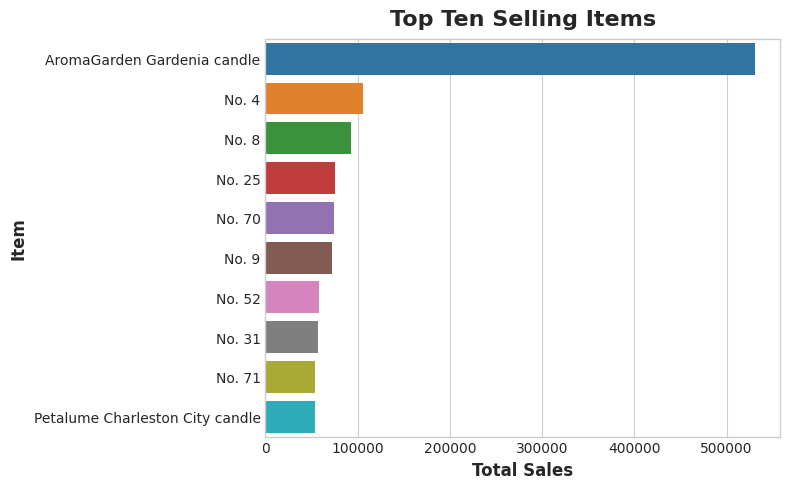

In [78]:
combined_desc_saleslim = combined_desc_sales.head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=combined_desc_saleslim.values, y=combined_desc_saleslim.index)

plt.title('Top Ten Selling Items')
plt.xlabel('Total Sales')
plt.ylabel('Item')
plt.show()

The difference between items is very small after the first few. Setting these up as features to see if they have an impact on the model. 

In [80]:

desc_test = test.groupby('Description')['Sales'].sum()
desc_test = desc_test.sort_values(ascending=False).head(10)

print(desc_test)

Description
AromaGarden Gardenia candle       16578.80
Petalume No. 76 9 oz               3593.64
Private candle-Making Workshop     3406.00
Petalume No. 49  9oz               2091.28
Petalume No. 94  9oz               1599.96
Petalume No. 88 9 oz               1560.64
Petalume No. 31 9 oz               1557.56
Petalume No. 8 9 oz                1501.40
Petalume No. 25 9 oz               1439.72
Petalume No. 18 9 oz               1362.48
Name: Sales, dtype: float64


In [81]:
# combine the similar items
desc_test_df = desc_test.reset_index()
desc_test_df.columns = ['Description', 'Sales']


def combine_specific_descriptions(desc):
    if re.search(r'No\. 4(\D|$)', desc):
        return 'No. 4'
    elif re.search(r'No\. 8(\D|$)', desc):
        return 'No. 8'
    elif re.search(r'No\. 25(\D|$)', desc):
        return 'No. 25'
    elif re.search(r'No\. 12(\D|$)', desc):
        return 'No. 12'
    elif re.search(r'No\. 70(\D|$)', desc):
        return 'No. 70'
    elif re.search(r'No\. 9(\D|$)', desc):
        return 'No. 9'
    elif re.search(r'No\. 52(\D|$)', desc):
        return 'No. 52'
    elif re.search(r'No\. 71(\D|$)', desc):
        return 'No. 71'
    elif re.search(r'No\. 88(\D|$)', desc):
        return 'No. 88'
    elif re.search(r'No\. 40(\D|$)', desc):
        return 'No. 40'
    elif re.search(r'No\. 18(\D|$)', desc):
        return 'No. 18'
    elif re.search(r'No\. 1(\D|$)', desc):
        return 'No. 1'
    elif re.search(r'No\. 31(\D|$)', desc):
        return 'No. 31'
    elif re.search(r'No\. 100(\D|$)', desc):
        return 'No. 100'
    elif re.search(r'No\. 67(\D|$)', desc):
        return 'No. 67'
    elif re.search(r'No\. 59(\D|$)', desc):
        return 'No. 59'
    elif re.search(r'No\. 72(\D|$)', desc):
        return 'No. 72'
    elif re.search(r'No\. 68(\D|$)', desc):
        return 'No. 68'
    elif re.search(r'No\. 64(\D|$)', desc):
        return 'No. 64'
    elif re.search(r'No\. 83(\D|$)', desc):
        return 'No. 83'
    elif re.search(r'No\. 53(\D|$)', desc):
        return 'No. 53'
    elif re.search(r'No\. 76(\D|$)', desc):
        return 'No. 76'
    elif re.search(r'No\. 90(\D|$)', desc):
        return 'No. 90'
    else:
        return desc


desc_test_df['Description'] = desc_test_df['Description'].apply(combine_specific_descriptions)

# Group by the new description and sum the sales
combined_desc_sales = desc_test_df.groupby('Description')['Sales'].sum()

# Sort the values if needed
combined_desc_salestest = combined_desc_sales.sort_values(ascending=False)

combined_desc_salestest.head(10)

Description
AromaGarden Gardenia candle       16578.80
No. 76                             3593.64
Private candle-Making Workshop     3406.00
Petalume No. 49  9oz               2091.28
Petalume No. 94  9oz               1599.96
No. 88                             1560.64
No. 31                             1557.56
No. 8                              1501.40
No. 25                             1439.72
No. 18                             1362.48
Name: Sales, dtype: float64

In [82]:
combined_desc_salestest=combined_desc_salestest.head(10)

set1 = set(combined_desc_saleslim.index)
set2 = set(combined_desc_salestest.index)

common_items = set1.intersection(set2)
common_items_list = list(common_items)
print(common_items_list)

['No. 8', 'AromaGarden Gardenia candle', 'No. 31', 'No. 25']


These are the brands in common in the top ten for the training and test sets. 


In [83]:

common_items_list.append('Shipping')
def categorize_item(item):
    item_str = str(item)
    for common_item in common_items_list:
        if common_item in item_str:
            return common_item
    return 'Other'

train_at['Common_Item'] = train_at['Description'].apply(categorize_item)
test_at['Common_Item'] = test_at['Description'].apply(categorize_item)


# Create dummy variables
item_dummies_train = pd.get_dummies(train_at['Common_Item']).astype(int)
item_dummies_test = pd.get_dummies(test_at['Common_Item']).astype(int)

# Checking the result
item_dummies_train.head()


,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Other,Shipping
Date,,,,,,
2018-04-26,0,0,0,0,1,0
2018-04-26,0,0,0,0,1,0
2018-04-26,0,0,0,0,1,0
2018-04-26,0,0,0,0,1,0
2018-04-26,0,0,0,0,1,0


In [84]:
item_dummies_test.head()

,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Other,Shipping
Date,,,,,,
2020-03-03,0,0,0,0,1,0
2020-03-03,0,0,0,0,1,0
2020-03-03,0,0,0,0,1,0
2020-03-03,0,0,0,0,1,0
2020-03-03,0,0,0,0,1,0


In [85]:
#shipping
train_at['Common_Item'] = train_at['Description'].apply(categorize_item)
test_at['Common_Item'] = test_at['Description'].apply(categorize_item)


# Create dummy variables
item_dummies_train = pd.get_dummies(train_at['Common_Item']).astype(int)
item_dummies_test = pd.get_dummies(test_at['Common_Item']).astype(int)

In [86]:
item_dummies_train = item_dummies_train.drop(['Other'], axis =1)
item_dummies_test = item_dummies_test.drop(['Other'], axis =1)
item_dummies_train.head()

,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
Date,,,,,
2018-04-26,0,0,0,0,0
2018-04-26,0,0,0,0,0
2018-04-26,0,0,0,0,0
2018-04-26,0,0,0,0,0
2018-04-26,0,0,0,0,0


In [87]:
item_dummies_test.head()

,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
Date,,,,,
2020-03-03,0,0,0,0,0
2020-03-03,0,0,0,0,0
2020-03-03,0,0,0,0,0
2020-03-03,0,0,0,0,0
2020-03-03,0,0,0,0,0


In [88]:
item_dummies_train_agg = item_dummies_train.groupby('Date').sum()
item_dummies_test_agg = item_dummies_test.groupby('Date').sum()
item_dummies_train_agg = item_dummies_train_agg.reset_index()
item_dummies_test_agg = item_dummies_test_agg.reset_index()
item_dummies_train_agg.head()

,Date,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
0,2018-04-26,0,0,0,12,0
1,2018-04-27,0,0,0,42,0
2,2018-04-28,0,72,0,84,0
3,2018-04-29,0,24,24,48,0
4,2018-04-30,0,0,0,42,0


In [89]:
item_dummies_test_agg.head()

,Date,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
0,2020-03-03,186,6,12,24,0
1,2020-03-04,0,0,12,48,1
2,2020-03-05,0,48,0,36,0
3,2020-03-06,186,24,48,78,9
4,2020-03-07,372,72,108,342,5


In [90]:
aggsale_test.head()

,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume
0,2020-03-03,3887.75,0,242,242,0,10,2,248,0,276,15,0,21,0,368
1,2020-03-04,1913.80,0,164,164,1,4,0,172,6,51,9,3,18,6,357
2,2020-03-05,2734.92,0,178,178,0,4,0,189,0,66,24,0,18,6,402
3,2020-03-06,8847.66,0,636,636,9,36,0,627,5,333,45,3,57,6,1344
4,2020-03-07,16059.85,0,1045,1045,5,47,1,1028,22,687,108,15,108,18,1953


In [91]:
aggsale_train = aggsale_train.merge(item_dummies_train_agg, on='Date', how='left')
aggsale_test = aggsale_test.merge(item_dummies_test_agg, on='Date', how='left')
aggsale_train.head()

,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,...,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
0,2018-04-26,1169.49,0,87.0,87.0,0.0,22.0,0.0,70.0,2.0,...,0.0,12.0,0.0,0.0,120.0,0.0,0.0,0.0,12.0,0.0
1,2018-04-27,1207.30,0,122.0,122.0,0.0,15.0,0.0,119.0,4.0,...,0.0,6.0,3.0,6.0,183.0,0.0,0.0,0.0,42.0,0.0
2,2018-04-28,4527.43,0,316.0,316.0,0.0,54.0,1.0,272.0,2.0,...,0.0,60.0,12.0,6.0,660.0,0.0,72.0,0.0,84.0,0.0
3,2018-04-29,3248.53,0,260.0,260.0,0.0,22.0,0.0,260.0,0.0,...,0.0,12.0,33.0,18.0,525.0,0.0,24.0,24.0,48.0,0.0
4,2018-04-30,1714.37,0,115.0,115.0,0.0,27.0,1.0,94.0,2.0,...,0.0,6.0,3.0,0.0,159.0,0.0,0.0,0.0,42.0,0.0


In [92]:
aggsale_test.head()

,Date,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,...,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
0,2020-03-03,3887.75,0,242,242,0,10,2,248,0,...,15,0,21,0,368,186,6,12,24,0
1,2020-03-04,1913.80,0,164,164,1,4,0,172,6,...,9,3,18,6,357,0,0,12,48,1
2,2020-03-05,2734.92,0,178,178,0,4,0,189,0,...,24,0,18,6,402,0,48,0,36,0
3,2020-03-06,8847.66,0,636,636,9,36,0,627,5,...,45,3,57,6,1344,186,24,48,78,9
4,2020-03-07,16059.85,0,1045,1045,5,47,1,1028,22,...,108,15,108,18,1953,372,72,108,342,5


In [93]:
aggsale_train.set_index('Date', inplace=True)
aggregated_train = aggsale_train.groupby('Date').sum()
aggsale_test.set_index('Date', inplace=True)
aggregated_test = aggsale_test.groupby('Date').sum()

# Check the result
aggregated_test.head()


,Sales,Store_closed,Cost of Goods,Inventory,Logistics,Revenue Accessories,Revenue Workshop,Revenue candles,nan,AromaGarden,Bliss Bungalow,Cozy Corner,Hearth Harbor,Meadow Mingle,Petalume,AromaGarden Gardenia candle,No. 25,No. 31,No. 8,Shipping
Date,,,,,,,,,,,,,,,,,,,,
2020-03-03,3887.75,0,242,242,0,10,2,248,0,276,15,0,21,0,368,186,6,12,24,0
2020-03-04,1913.80,0,164,164,1,4,0,172,6,51,9,3,18,6,357,0,0,12,48,1
2020-03-05,2734.92,0,178,178,0,4,0,189,0,66,24,0,18,6,402,0,48,0,36,0
2020-03-06,8847.66,0,636,636,9,36,0,627,5,333,45,3,57,6,1344,186,24,48,78,9
2020-03-07,16059.85,0,1045,1045,5,47,1,1028,22,687,108,15,108,18,1953,372,72,108,342,5


In [94]:
aggsale_train = aggsale_train.asfreq('D')
aggsale_test = aggsale_test.asfreq('D')

# Fill NaN values with 0
aggsale_train.fillna(0, inplace=True)
aggsale_test.fillna(0, inplace=True)
aggsale_train.isna().sum()

Sales                          0
Store_closed                   0
Cost of Goods                  0
Inventory                      0
Logistics                      0
Revenue Accessories            0
Revenue Workshop               0
Revenue candles                0
nan                            0
AromaGarden                    0
Bliss Bungalow                 0
Cozy Corner                    0
Hearth Harbor                  0
Meadow Mingle                  0
Petalume                       0
AromaGarden Gardenia candle    0
No. 25                         0
No. 31                         0
No. 8                          0
Shipping                       0
dtype: int64

In [95]:
aggsale_test.isna().sum()

Sales                          0
Store_closed                   0
Cost of Goods                  0
Inventory                      0
Logistics                      0
Revenue Accessories            0
Revenue Workshop               0
Revenue candles                0
nan                            0
AromaGarden                    0
Bliss Bungalow                 0
Cozy Corner                    0
Hearth Harbor                  0
Meadow Mingle                  0
Petalume                       0
AromaGarden Gardenia candle    0
No. 25                         0
No. 31                         0
No. 8                          0
Shipping                       0
dtype: int64

In [97]:
y = aggsale_train.copy()

fourier = CalendarFourier(freq='M', order=4)
fourier_annual = CalendarFourier(freq='A', order=4)#add weekly too, only has monthly, weird
fourier_weekly = CalendarFourier(freq='W', order=4)
fourier_quarterly = CalendarFourier(freq='Q', order=4)# Quarterly Fourier
# Bimonthly Fourier
fourier_bimonthly = CalendarFourier(freq='2M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier,fourier_weekly,fourier_annual,fourier_quarterly, fourier_bimonthly],
    drop=True,
)
X = dp.in_sample()


X['Xmas25'] = ((X.index.month == 12) & (X.index.day == 25)).astype(int)
X['Xmas24'] = ((X.index.month == 12) & (X.index.day == 24)).astype(int)
X['Xmas23'] = ((X.index.month == 12) & (X.index.day == 23)).astype(int)
X['Xmas22'] = ((X.index.month == 12) & (X.index.day == 22)).astype(int)
X['Xmas21'] = ((X.index.month == 12) & (X.index.day == 21)).astype(int)
X['Xmas20'] = ((X.index.month == 12) & (X.index.day == 20)).astype(int)
X['Xmas18'] = ((X.index.month == 12) & (X.index.day == 18)).astype(int)
X['Xmas14'] = ((X.index.month == 12) & (X.index.day == 14)).astype(int)
X['Store_closed'] = aggsale_train['Store_closed']

X['Cost of Goods'] = aggsale_train['Cost of Goods']
#X['Inventory'] = aggsale_train['Inventory']
X['Logistics'] = aggsale_train['Logistics']
X['Revenue Accessories'] = aggsale_train['Revenue Accessories']
X['Revenue candles'] = aggsale_train['Revenue candles']
X['Revenue Workshop'] = aggsale_train['Revenue Workshop']
X['nan'] = aggsale_train['nan']

X['Cozy Corner'] = aggsale_train['Cozy Corner']
X['Petalume'] = aggsale_train['Petalume']
X['Bliss Bungalow'] = aggsale_train['Bliss Bungalow']
X['AromaGarden'] = aggsale_train['AromaGarden']
X['Hearth Harbor'] = aggsale_train['Hearth Harbor']
X['Meadow Mingle'] = aggsale_train['Meadow Mingle']

#X['No. 8'] = aggsale_train['No. 8']
#X['AromaGarden Gardenia candle'] = aggsale_train['AromaGarden Gardenia candle']
#X['No. 31'] = aggsale_train['No. 31']
#X['No. 25'] = aggsale_train['No. 25']
X['Shipping'] = aggsale_train['Shipping']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

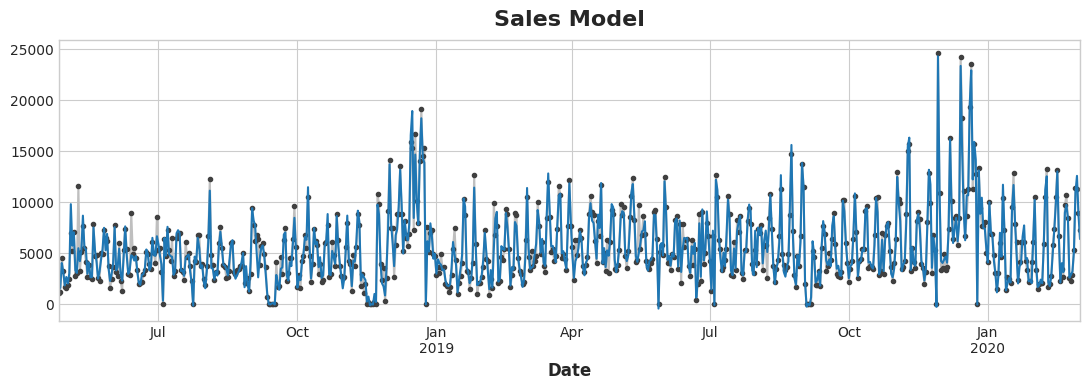

In [98]:
# use this cell to see some of the predictions

ax = y.loc(axis=1)['Sales'].plot(**plot_params)
ax = y_pred.loc(axis=1)['Sales'].plot(ax=ax)
ax.set_title('Sales Model');

In [99]:
model = LinearRegression(fit_intercept=False)
#model.fit(X, y)
model.fit(X, y['Sales'])


# Predict for in-sample and out-of-sample
y_pred_insample = pd.DataFrame(model.predict(X), index=X.index, columns=['Sales'])

In [100]:

def rmsle(y_true, y_pred):
    
    # Ensure the arrays are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute the squared logarithmic error
    error = (np.log(y_pred + 1) - np.log(y_true + 1)) ** 2
    
    # Return the square root of the mean of the squared logarithmic error
    return np.sqrt(np.mean(error))



In [101]:
# there are negative predictions in the data, for now clip them to 0 or low pos near 0 to make the calc work
# Clip negative predictions to 0
y_pred_insample['Sales'] = y_pred_insample['Sales'].clip(lower=0)

# Now, compute RMSLE
in_sample_rmsle = rmsle(y['Sales'], y_pred_insample['Sales'])
print(f"In-sample RMSLE: {in_sample_rmsle}")

In-sample RMSLE: 0.568794992114068


In [102]:
#creates feature set for the forecast data (out_of_sample) 

X_test = dp.out_of_sample(steps=15)
X_test['Xmas25'] = ((X_test.index.month == 12) & (X_test.index.day == 25)).astype(int)
X_test['Xmas24'] = ((X_test.index.month == 12) & (X_test.index.day == 24)).astype(int)
X_test['Xmas23'] = ((X_test.index.month == 12) & (X_test.index.day == 23)).astype(int)
X_test['Xmas22'] = ((X_test.index.month == 12) & (X_test.index.day == 22)).astype(int)
X_test['Xmas21'] = ((X_test.index.month == 12) & (X_test.index.day == 21)).astype(int)
X_test['Xmas20'] = ((X_test.index.month == 12) & (X_test.index.day == 20)).astype(int)
X_test['Xmas18'] = ((X_test.index.month == 12) & (X_test.index.day == 18)).astype(int)
X_test['Xmas14'] = ((X_test.index.month == 12) & (X_test.index.day == 14)).astype(int)
X_test['Store_closed'] = aggsale_test['Store_closed']

X_test['Cost of Goods'] = aggsale_test['Cost of Goods']
#X_test['Inventory'] = aggsale_test['Inventory']
X_test['Logistics'] = aggsale_test['Logistics']
X_test['Revenue Accessories'] = aggsale_test['Revenue Accessories']
X_test['Revenue candles'] = aggsale_test['Revenue candles']
X_test['Revenue Workshop'] = aggsale_test['Revenue Workshop']
X_test['nan'] = aggsale_test['nan']

X_test['Cozy Corner'] = aggsale_test['Cozy Corner']
X_test['Petalume'] = aggsale_test['Petalume']
X_test['Bliss Bungalow'] = aggsale_test['Bliss Bungalow']
X_test['AromaGarden'] = aggsale_test['AromaGarden']
X_test['Hearth Harbor'] = aggsale_test['Hearth Harbor']
X_test['Meadow Mingle'] = aggsale_test['Meadow Mingle']

#X_test['No. 8'] = aggsale_test['No. 8']
#X_test['AromaGarden Gardenia candle'] = aggsale_test['AromaGarden Gardenia candle']
#X_test['No. 31'] = aggsale_test['No. 31']
#X_test['No. 25'] = aggsale_test['No. 25']
X_test['Shipping'] = aggsale_test['Shipping']




In [103]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y['Sales'])
y_pred_outsample = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['Sales'])

In [104]:
out_sample_rmsle = rmsle(aggsale_test['Sales'], y_pred_outsample['Sales'])
print(f"Out-of-sample RMSLE: {out_sample_rmsle}")

Out-of-sample RMSLE: 0.1279699103625324
